In [1]:
#####################################################
# Author: Prof. Marc Jofre
# Dept. Network Engineering
# Universitat Politècnica de Catalunya - Technical University of Catalonia
#
# Modified: 2024
# Created: 2024
#
# Script Quantum LAN application Client layer
#####################################################
import sys, os
# print("Python version:", sys.version)
# !pip install numpy
import numpy as np
#!pip install --upgrade pip
#!pip install --upgrade pillow
#!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
#from google.colab import files
#print(plt.style.available)
mpl.style.use('default')
import time

pathScriptBelowAgentScript='./CppScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptBelowAgentScript='./JupyterPythonScripts/'
sys.path.append(pathScriptBelowAgentScript)
pathScriptData='../../GeneratedDataPythonJupyter/'

import QpresentationLayerAgent
#####################################################
# Parameters
## Network
IPhostClientOpNet = "10.0.0.1" # IP address of the client host (this host) in the operation network
IPhostClientConNet = "192.168.8.1" # IP address of the client host (this host) in the contro/configuration network
IPnodeClientConNet = "192.168.8.2" # IP address of the client node (connected to the client host) in the control/configuration network
IPhostServerOpNet = "127.0.0.1"#10.0.0.3" # IP address of the server host in the operation network
IPnodeServerConNet = "192.168.9.2" # IP address of the server node in the control/configuration network

ParamsClientListChar = [IPnodeClientConNet,IPhostServerOpNet,IPhostClientOpNet,IPhostClientConNet,"client"]

##############################################################
# Functions
def ListCharArrayParser(ListCharArrayAux):
    # Actually concatenating a python list of strings to a single string
    ParsedCharArrayAux=",".join(ListCharArrayAux)+","
    return ParsedCharArrayAux

# The parameters passed and received from agents are structured
ParamsAscendingCharArray = "none"
ParamsDescendingCharArray = ListCharArrayParser(ParamsClientListChar)

### RUN UP TO HERE (INCLUDED) TO INITIALIZE CONNECTIONS AND THREAD QtransportLayerAgentH thread #####
# At this point, in this order, the node in the server has been initialized, the node in the client, the server host (up to this equivalent point) and then the client host (up to here)
# Create instance of Agent below
QPLAagent = QpresentationLayerAgent.QPLA(ParamsDescendingCharArray,ParamsAscendingCharArray)
### Initiate thread process in QtransportLayerAgentH
QPLAagent.InitAgentProcess() # Initialize the thread in QtransportLayerAgentH

In [ ]:
#####################
# Some tests to send information to the different elements and see them output at the respective console
# The required fields of a message are (separated by commas): IPdestination,IPorigin,Type,Command,Payload
messagePayloadAux="Host client sends information to attached node"
messageCommandAux="print"
messageTypeAux="Info"
messageIPorg=IPhostClientOpNet
messageIPdest=IPnodeClientConNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host client sends information to server host"
messageCommandAux="print"
messageTypeAux="Info"
messageIPorg=IPhostClientOpNet
messageIPdest=IPhostServerOpNet
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

messagePayloadAux="Host client sends information to host server node"
messageCommandAux="print"
messageTypeAux="Control"
messageIPorg=IPhostClientOpNet
messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
QPLAagent.SendMessageAgent(messageAuxChar)

In [2]:
#### Some test to request QuBits from the other host #################
QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128) # Request that host's node sends qubits to this host's node
NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.single)# equivalnet to float32 for C like arrays
QPLAagent.SimulateRetrieveNumStoredQubitsNode(NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
print('NumStoredQubitsNode[0]: '+str(NumStoredQubitsNode[0]))
print('StatisticsTimeTagDetStoredQubitsNode: '+str(StatisticsTimeTagDetStoredQubitsNode))

NumStoredQubitsNode[0]: 2048
StatisticsTimeTagDetStoredQubitsNode: [2.0480000e+03 2.0480000e+03 2.0480000e+03 2.0480000e+03 2.0480000e+03
 1.9990620e+01 9.3799997e-03 4.3117993e+09]


In [3]:
###### Hard resilience test #######
import random
import time
NumTestMax = 10
ListNumStoredQubitsNode=[]
ListStatisticsTimeTaggDetQubitsNodeParam0=[]
ListStatisticsTimeTaggDetQubitsNodeParam1=[]
ListStatisticsTimeTaggDetQubitsNodeParam2=[]
ListStatisticsTimeTaggDetQubitsNodeParam3=[]
ListStatisticsTimeTaggDetQubitsNodeParam4=[]
ListStatisticsTimeTaggDetQubitsNodeParam5=[]
ListStatisticsTimeTaggDetQubitsNodeParam6=[]
ListStatisticsTimeTaggDetQubitsNodeParam7=[]
for iIterTest in range(0,NumTestMax,1):
    RandomTestNum=random.randint(0, 1)
    if (RandomTestNum==0):
        # Sending messages
        messagePayloadAux="Host client sends information to attached node"
        messageCommandAux="print"
        messageTypeAux="Info"
        messageIPorg=IPhostClientOpNet
        messageIPdest=IPnodeClientConNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host client sends information to server host"
        messageCommandAux="print"
        messageTypeAux="Info"
        messageIPorg=IPhostClientOpNet
        messageIPdest=IPhostServerOpNet
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
        time.sleep(0.1)
        messagePayloadAux="Host client sends information to host server node"
        messageCommandAux="print"
        messageTypeAux="Control"
        messageIPorg=IPhostClientOpNet
        messageIPdest=IPhostServerOpNet # Notice that it is send to the host (which it will forward it to the node)
        messageAuxChar = ListCharArrayParser([messageIPdest,messageIPorg,messageTypeAux,messageCommandAux,messagePayloadAux])
        QPLAagent.SendMessageAgent(messageAuxChar)
    else:
        # Sending request
        QPLAagent.SimulateRequestQubitsHost(IPhostServerOpNet,IPhostClientOpNet,IPnodeClientConNet,IPhostClientOpNet,128) # Request that host's node sends qubits to this host's node
        NumStoredQubitsNode = np.zeros(1, dtype=np.intc)# np.array([0], dtype=np.intc)
        StatisticsTimeTagDetStoredQubitsNode = np.zeros(8, dtype=np.single)# equivalnet to float32 for C like arrays
        QPLAagent.SimulateRetrieveNumStoredQubitsNode(NumStoredQubitsNode,StatisticsTimeTagDetStoredQubitsNode) # Supposing that node has received quBits, return number of QuBits
        ListNumStoredQubitsNode.append(NumStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam0.append(StatisticsTimeTagDetStoredQubitsNode[0])
        ListStatisticsTimeTaggDetQubitsNodeParam1.append(StatisticsTimeTagDetStoredQubitsNode[1])
        ListStatisticsTimeTaggDetQubitsNodeParam2.append(StatisticsTimeTagDetStoredQubitsNode[2])
        ListStatisticsTimeTaggDetQubitsNodeParam3.append(StatisticsTimeTagDetStoredQubitsNode[3])
        ListStatisticsTimeTaggDetQubitsNodeParam4.append(StatisticsTimeTagDetStoredQubitsNode[4])
        ListStatisticsTimeTaggDetQubitsNodeParam5.append(StatisticsTimeTagDetStoredQubitsNode[5])
        ListStatisticsTimeTaggDetQubitsNodeParam6.append(StatisticsTimeTagDetStoredQubitsNode[6])
        ListStatisticsTimeTaggDetQubitsNodeParam7.append(StatisticsTimeTagDetStoredQubitsNode[7])
    time.sleep(15.0)
    time.sleep(int(15.0*random.uniform(0,1)))
print('ListNumStoredQubitsNode: '+str(ListNumStoredQubitsNode))
print('ListStatisticsTimeTaggDetQubitsNodeParam0: '+str(ListStatisticsTimeTaggDetQubitsNodeParam0))
print('ListStatisticsTimeTaggDetQubitsNodeParam1: '+str(ListStatisticsTimeTaggDetQubitsNodeParam1))
print('ListStatisticsTimeTaggDetQubitsNodeParam2: '+str(ListStatisticsTimeTaggDetQubitsNodeParam2))
print('ListStatisticsTimeTaggDetQubitsNodeParam3: '+str(ListStatisticsTimeTaggDetQubitsNodeParam3))
print('ListStatisticsTimeTaggDetQubitsNodeParam4: '+str(ListStatisticsTimeTaggDetQubitsNodeParam4))
print('ListStatisticsTimeTaggDetQubitsNodeParam5: '+str(ListStatisticsTimeTaggDetQubitsNodeParam5))
print('ListStatisticsTimeTaggDetQubitsNodeParam6: '+str(ListStatisticsTimeTaggDetQubitsNodeParam6))
print('ListStatisticsTimeTaggDetQubitsNodeParam7: '+str(ListStatisticsTimeTaggDetQubitsNodeParam7))

ListNumStoredQubitsNode: [2048, 2048, -1, 2048, 2048]
ListStatisticsTimeTaggDetQubitsNodeParam0: [2048.0, 1788.0, 0.0, 2048.0, 2048.0]
ListStatisticsTimeTaggDetQubitsNodeParam1: [2048.0, 2032.0, 0.0, 2048.0, 2048.0]
ListStatisticsTimeTaggDetQubitsNodeParam2: [2048.0, 2029.0, 0.0, 2048.0, 2048.0]
ListStatisticsTimeTaggDetQubitsNodeParam3: [2048.0, 2048.0, 0.0, 2048.0, 2048.0]
ListStatisticsTimeTaggDetQubitsNodeParam4: [2048.0, 2033.0, 0.0, 2048.0, 2048.0]
ListStatisticsTimeTaggDetQubitsNodeParam5: [19.99062, 19.99062, 0.0, 19.99062, 19.99062]
ListStatisticsTimeTaggDetQubitsNodeParam6: [0.00938, 0.00938, 0.0, 0.00938, 0.00938]
ListStatisticsTimeTaggDetQubitsNodeParam7: [8606766000.0, 17284393000.0, 0.0, 36802080000.0, 49409053000.0]


In [4]:
# Save generated data
#print(os.getcwd())
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
np.save(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString,ListNumStoredQubitsNode)
np.save(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam0)
np.save(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam1)
np.save(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam2)
np.save(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam3)
np.save(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam4)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam5)
np.save(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam6)
np.save(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString,ListStatisticsTimeTaggDetQubitsNodeParam7)

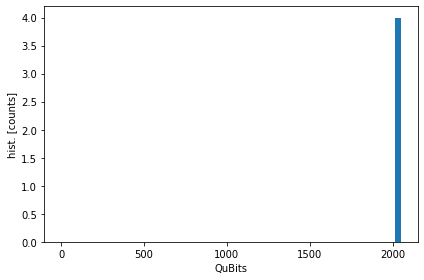

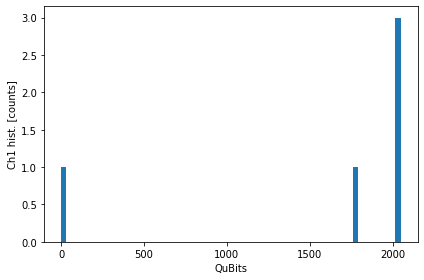

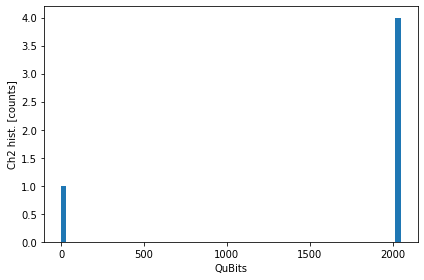

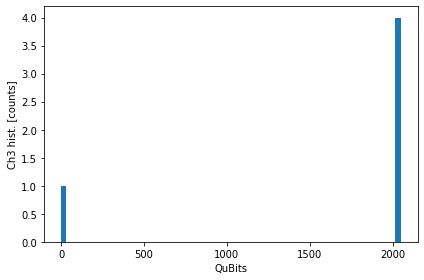

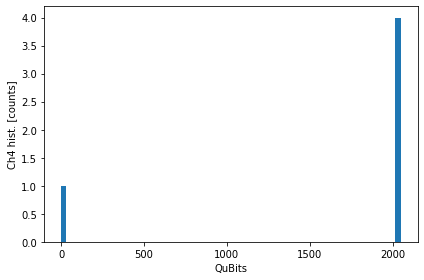

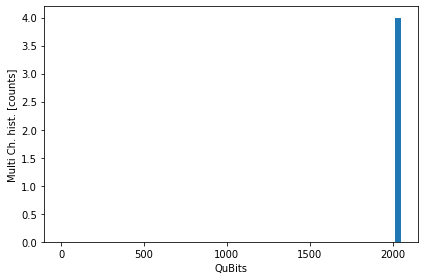

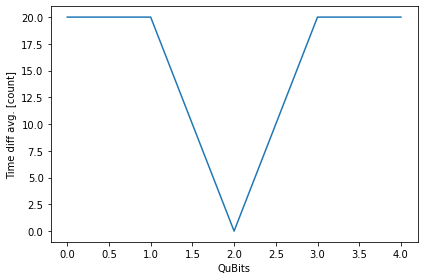

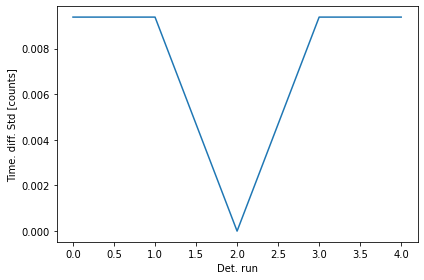

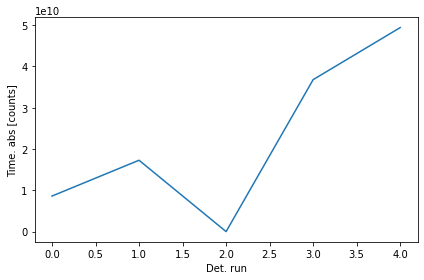

In [5]:
# Plot ListNumStoredQubitsNode data
ExtraDetailString='PTP'#'NoPTP'#'NoPTP'
ListNumStoredQubitsNode=np.load(pathScriptData+'ClientListNumStoredQubitsNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam0=np.load(pathScriptData+'ClientListNumStoredQubitsCh1Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam0,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch1 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam1=np.load(pathScriptData+'ClientListNumStoredQubitsCh2Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam1,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch2 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam2=np.load(pathScriptData+'ClientListNumStoredQubitsCh3Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam2,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch3 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam3=np.load(pathScriptData+'ClientListNumStoredQubitsCh4Node'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListStatisticsTimeTaggDetQubitsNodeParam3,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Ch4 hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam4=np.load(pathScriptData+'ClientListNumStoredQubitsMultiNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.hist(ListNumStoredQubitsNode,bins=np.arange(0,2049,32))
plt.xlabel('QuBits')
plt.ylabel('Multi Ch. hist. [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam5=np.load(pathScriptData+'ClientListNumStoredQubitsTdiffAvgNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam5),1),ListStatisticsTimeTaggDetQubitsNodeParam5)
plt.xlabel('QuBits')
plt.ylabel('Time diff avg. [count]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam6=np.load(pathScriptData+'ClientListNumStoredQubitsTdiffStdNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam6),1),ListStatisticsTimeTaggDetQubitsNodeParam6)
plt.xlabel('Det. run')
plt.ylabel('Time. diff. Std [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()

ListStatisticsTimeTaggDetQubitsNodeParam7=np.load(pathScriptData+'ClientListNumStoredQubitsTabsNode'+ExtraDetailString+'.npy')
plt.figure()#figsize=(8.0, 4.0))
ax = plt.gca()
plt.plot(np.arange(0,len(ListStatisticsTimeTaggDetQubitsNodeParam7),1),ListStatisticsTimeTaggDetQubitsNodeParam7)
plt.xlabel('Det. run')
plt.ylabel('Time. abs [counts]')
#plt.title('Antenna Throughput Comparison')
#plt.ylim(0, max(throughput_values) + 10)  # Adjust the y-axis limit for better visualization
plt.tight_layout()
#plt.savefig(pathScriptData+'TheorLOSvsNLOS.pdf', bbox_inches='tight', format = 'pdf', dpi = 300 )#dpi = 600 )
plt.show()
